In [28]:
#Import external packages
import matplotlib.pyplot as plt
import numpy as np
import sys
import random
from scipy.integrate import odeint as ode
import torch
import pandas as pd

In [29]:
#Import local functions
sys.path.append('../functions')
from functions import dual_control_scipy, loss_biological

In [30]:
def simple_solve(alpha1, alpha2):
    '''Solves dual control system for a variety of ks using scipy solvers'''
    #Solve using simple solvers
    ks = np.linspace(1E-7, 0.001, 10)
    theta1 = 0.1

    int_time = 5E4
    t = torch.linspace(0, int_time, 100) 
    y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 

    ss_data = pd.DataFrame(columns=['theta', 'k1', 'k2', 'j1', 'j2', 'loss'])

    for k1 in ks:
        for k2 in ks:
            pred = ode(dual_control_scipy, y0, t, args=(2, 2, theta1, theta1, k1, k2))
            j1, j2, loss = loss_biological(pred, alpha1=alpha1, alpha2=alpha2)
            row = [theta1, k1, k2, j1, j2, loss]
            ss_data.loc[len(ss_data)] = row
    
    #Compute gradients of loss landscape
    loss = ss_data.pivot_table(index='k1', columns='k2', values='loss').T.values
    j1 = ss_data.pivot_table(index='k1', columns='k2', values='j1').T.values
    j2 = ss_data.pivot_table(index='k1', columns='k2', values='j2').T.values
    k1_unique = np.sort(ss_data.k1.unique())
    k2_unique = np.sort(ss_data.k2.unique())
    k1s, k2s = np.meshgrid(k1_unique, k2_unique)
    gradient = np.gradient(loss)
    #Normalize gradient for vector field
    norm = np.sqrt(gradient[0]**2 + gradient[1]**2)
    norm_grad_x = gradient[0] / norm
    norm_grad_y = gradient[1] / norm
    mag_gradient = gradient[0] + gradient[1]
    return k1s, k2s, j1, j2, loss, gradient, norm_grad_x, norm_grad_y, mag_gradient
    
k1s, k2s, j1, j2, loss_landscape, gradient, norm_grad_x, norm_grad_y, mag_gradient = simple_solve(1E-5, 1E-2)

In [33]:
patch_size = 50
step_size = 0.0001
num_epochs = 10

alpha1 = 1E-5
alpha2 = 1E-2

int_time = 5E4
t = np.linspace(0, int_time, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 
losses = []
theta1 = 0.1
def solve_patch(k1, k2, patch_size, step_size):
    pred = ode(dual_control_scipy, y0, t, args=(2, 2, 0.1, 0.1, k1, k2))
    j1, j2, center_loss = loss_biological(pred, alpha1=alpha1, alpha2=alpha2)

    #Solve surrounding patch
    thetas = np.linspace(0, 2*np.pi, patch_size)
    k1s = step_size*np.cos(thetas) + k1
    k2s = step_size*np.sin(thetas) + k2

    min_loss = center_loss
    new_k1 = k1
    new_k2 = k2

    for k1, k2 in zip(k1s, k2s):
        pred = ode(dual_control_scipy, y0, t, args=(2, 2, theta1, theta1, k1, k2));
        j1, j2, loss = loss_biological(pred, alpha1=alpha1, alpha2=alpha2)
        if loss < min_loss:
            new_k1 = k1
            new_k2 = k2
            min_loss = loss
    return new_k1, new_k2, min_loss

#Select random initialization and solve once
krange = [1E-7, 0.001]
# k1 = random.uniform(krange[0], krange[1])
# k2 = random.uniform(krange[0], krange[1])
#Set initialization for better visaulization
k2 = 0.0008
k1 = 0.0002

k1_trace = []; k2_trace = []
for i in range(num_epochs):
    new_k1, new_k2, loss = solve_patch(k1, k2, patch_size, step_size)
    k1 = new_k1
    k2 = new_k2
    losses.append(loss)
    k1_trace.append(k1)
    k2_trace.append(k2)


Text(0, 0.5, 'Loss Value')

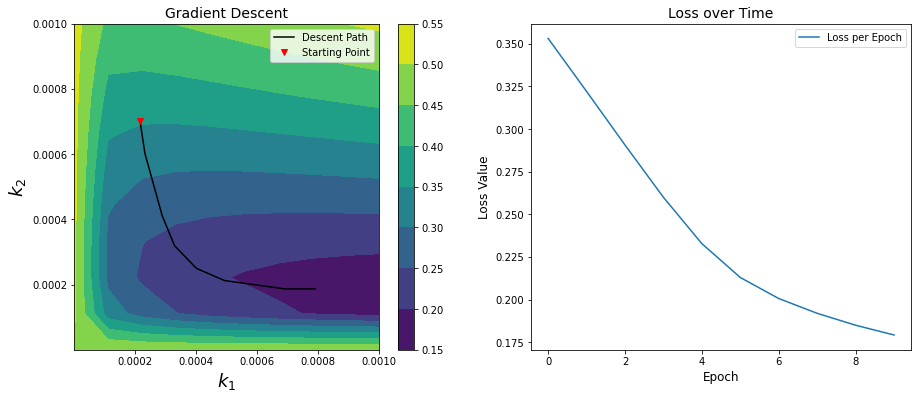

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'Gradient Descent'
ax = axs[0]
contour = ax.contourf(k1s,k2s,loss_landscape)
ax.plot(k1_trace, k2_trace, 'k-', label='Descent Path')
ax.plot(k1_trace[0], k2_trace[0], 'rv', label='Starting Point')
ax.legend()

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('$k_1$', fontsize=18)
ax.set_ylabel('$k_2$', fontsize=18)
fig.colorbar(contour, ax=ax)


endpoint = 'Loss over Time'
ax = axs[1]
ax.plot(losses, label='Loss per Epoch')
ax.legend()

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)

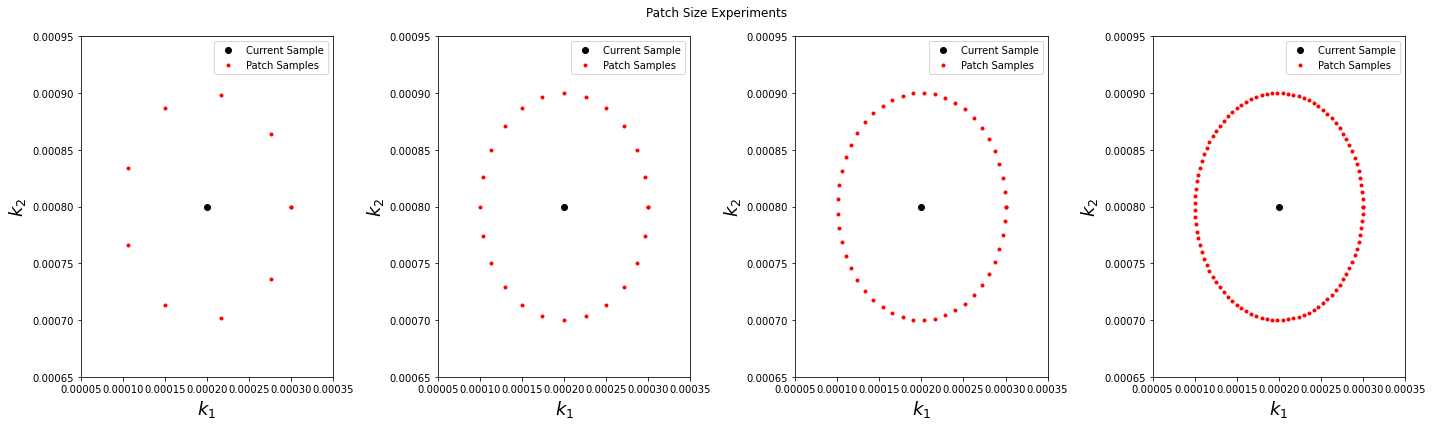

In [25]:
patch_size = [10, 25, 50, 100]
fig, axs = plt.subplots(1, len(patch_size), figsize=(20, 6))

k2 = 0.0008
k1 = 0.0002
for i in range(len(patch_size)):
    thetas = np.linspace(0, 2*np.pi, patch_size[i])
    k1s = step_size*np.cos(thetas) + k1
    k2s = step_size*np.sin(thetas) + k2

    ax = axs[i]
    ax.plot(k1, k2, 'ko', label='Current Sample')
    ax.plot(k1s, k2s, 'r.', label='Patch Samples')
    ax.set_xlim([k1-step_size*1.5, k1+step_size*1.5])
    ax.set_ylim([k2-step_size*1.5, k2+step_size*1.5])
    ax.legend()

    ax.set_xlabel('$k_1$', fontsize=18)
    ax.set_ylabel('$k_2$', fontsize=18)
fig.suptitle('Patch Size Experiments')
fig.tight_layout()

In [36]:
def read_fasta_filename2(filename):
    seq = ""

    with open(filename, 'r') as filehandle:

        for line in filehandle:

            if(line[0]== ">"):
                continue
            #OK but better to use a regular expression re.search(pattern, line):
            #eg re.search("^>",line)
            #We need to really search for ">" as the first character- there may be whitespaces!!

            seq= seq+ line

        #delete any whitespaces & quotes
        import re
        pattern = re.compile(r'\s+')
        seq = re.sub(pattern, '', seq)

        seq = seq.replace('\"', '')

        return seq

def create_matrix(rows, cols):
    return np.zeros([3, rows+1, cols+1])

def print_matrix(mymatrix):
    rows = len(mymatrix[0])
    cols = len(mymatrix[0][0])
    s1="  " +sequence1
    s2=" "+sequence2
    print('M Matrix')
    print("Dimensions: r= %2d , c= %2d" % (rows, cols))

    for a in s1:
        print(a, end ="")
        print(" \t", end ="")
    print("\n",end="")

    for i in range(0, rows):
        print(s2[i], end ="")
        print(" \t", end ="")
        for j in range(0, cols):
           print("%02d\t" % (mymatrix[0, i, j]),end="")
        print("\n",end="")

    print('X Matrix')
    for a in s1:
        print(a, end ="")
        print(" \t", end ="")
    print("\n",end="")

    for i in range(0, rows):
        print(s2[i], end ="")
        print(" \t", end ="")
        for j in range(0, cols):
           print("%02d\t" % (mymatrix[1, i, j]),end="")
        print("\n",end="")
    
    print('Y Matrix')
    for a in s1:
        print(a, end ="")
        print(" \t", end ="")
    print("\n",end="")

    for i in range(0, rows):
        print(s2[i], end ="")
        print(" \t", end ="")
        for j in range(0, cols):
           print("%02d\t" % (mymatrix[2, i, j]),end="")
        print("\n",end="")

#gets the max value from the built matrix
def get_max(mymatrix):
    max=mymatrix[0, 0, 0]
    mrow=0
    mcol=0
    mmat = 0
    rows = len(mymatrix[0])
    cols = len(mymatrix[0][0])
    for k in [0, 1, 2]:
        for i in range(1, rows):
            for j in range(1, cols):
                if mymatrix[k][i][j] > max:
                    max=mymatrix[k][i][j]
                    mrow=i
                    mcol=j
                    mmat = k
    print("max score: ",max)
    return [mmat, mrow,mcol]

def calc_score(matrix, x, y):
    sc = seqmatch if sequence1[y- 1] == sequence2[x - 1] else seqmismatch
    M_options = [matrix[0][x-1][y-1], matrix[1][x-1][y-1], matrix[2][x-1][y-1]]
    M = sc + max(M_options)
    M_decision = M_options.index(max(M_options))

    X_options = [gapopen + seqgap + matrix[0][x][y-1], seqgap + matrix[1][x][y-1], seqgap + gapopen + matrix[2][x][y-1]]
    X = max(X_options)
    X_decision = X_options.index(max(X_options))

    Y_options = [gapopen + seqgap + matrix[0][x-1][y], gapopen + seqgap + matrix[1][x-1][y], seqgap + matrix[2][x-1][y]]
    Y = max(Y_options)
    Y_decision = Y_options.index(max(Y_options))
    return [M,X,Y], [M_decision, X_decision, Y_decision]

def build_matrix(mymatrix):
    rows = len(mymatrix[0])
    cols = len(mymatrix[0][0])

    for i in range(1, rows):
        for j in range(1, cols):
            mymatrix[:, i, j], pointer[:, i, j] = calc_score(mymatrix, i, j)
    return mymatrix, pointer

def traceback(mymatrix, pointer, maxv):
    mat = maxv[0]
    x=maxv[1]
    y=maxv[2]
    val= int(pointer[mat, x, y])
    if mat == 0:
        return [val, x-1, y-1]
    if mat == 1:
        return [val, x-1, y]
    if mat == 2:
        return [val, x, y-1]

def print_traceback(mymatrix, pointer):
    #this will print as expected with internal gaps
   print("Building traceback...")
   maxv=get_max(mymatrix)
   print(maxv)

   #traverse the matrix to find the traceback elements
   #if more than one path just pick one
   topstring=""
   midstring=""
   bottomstring=""

   #pad the sequences so indexes into the sequences match the matrix indexes
   asequence1 = "#" + sequence1
   asequence2 = "#" + sequence2

   # add first element and go to previous
   topstring += asequence1[maxv[2]]
   bottomstring += asequence2[maxv[1]]
   if asequence1[maxv[2]] == asequence2[maxv[1]]:
       midstring += "|"
   else:
       midstring += " "

   #here we need to store the old position so we can track if it is an insertion of deletion
   #code assumes highest score cannot be a gap!
   old_maxv=maxv

   #add the rest of the elements
   search=True
   while(search):
       maxv=traceback(mymatrix, pointer,maxv)
       if(mymatrix[0, maxv[1]][maxv[2]]==0):
           search=False
           continue

        #deal with single gaps or matches
       if(old_maxv[2]==maxv[2]):
           topstring+="-"
           bottomstring +=asequence2[maxv[1]]
       elif(old_maxv[1] == maxv[1]):
            # insertion or deletion
           topstring += asequence1[maxv[2]]
           bottomstring += "-"
       else:
           # add the next element and go to previous
           topstring += asequence1[maxv[2]]
           bottomstring += asequence2[maxv[1]]

       if (asequence1[maxv[2] ] == asequence2[maxv[1] ]) & (old_maxv[-1]!=maxv[2]) & (old_maxv[1] != maxv[1]):
           midstring += "|"
       else:
           midstring += " "
       old_maxv = maxv

   print(topstring[::-1])
   print(midstring[::-1])
   print(bottomstring[::-1])

def perform_smith_waterman():
    global  seqmatch
    global  seqmismatch
    global  seqgap
    global gapopen
    global sequence1
    global sequence2

    import argparse
    import numpy as np

    parser = argparse.ArgumentParser(description='Aligning sequences...')
    parser.add_argument('seq1',action="store",help="First sequence")
    parser.add_argument('seq2',action="store",help="Second sequence")
    parser.add_argument('gap_penalty', action="store", help="Gap Penalty Type")

    margs = parser.parse_args()
    print(margs)

    #Load the sequences
    sequence1 = read_fasta_filename2(margs.seq1)
    sequence2 = read_fasta_filename2(margs.seq2)

    print("Sequence1: ",sequence1);
    print("Sequence2: "+sequence2);

    #Load gap penalties and align based on type
    if margs.gap_penalty == True:
        seqmatch = 1
        seqmismatch = -1
        gapopen = -1 #gap opening penalty
        seqgap = -1 #gap extension penalty
    else: 
        seqmatch =1
        seqmismatch=-1
        seqgap=-1
        gapopen=0

    mymatrix = create_matrix(len(sequence2), len(sequence1))
    pointer = create_matrix(len(sequence2), len(sequence1))
    mymatrix, pointer=build_matrix(mymatrix)

    print_matrix(mymatrix)
    print_traceback(mymatrix, pointer)
perform_smith_waterman()



usage: ipykernel_launcher.py [-h] seq1 seq2 gap_penalty
ipykernel_launcher.py: error: the following arguments are required: seq2, gap_penalty


SystemExit: 2